## Question 5
### Yellow Cab Vs Lyft Based on Passenger Count

In [1]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
extracted_files = glob.glob('..\\Data\\*\\*\\lyftdata\\*.csv')
df = pd.DataFrame()
list_ = []
for fileName in extracted_files:
    short_df = pd.read_csv(fileName)
    list_.append(short_df)
df = pd.concat(list_)

In [3]:
#Ignoring the outliars
df = df[df['tip_amount']<df['fare_amount']]
df['passenger_count'] = df['passenger_count'].apply(lambda x: 1 if x == 0 else x)

In [4]:
df.head()

,index,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,improvement_surcharge,total_amount,travel_date,pickup_area,dropoff_area,lyft_cost,lyft_plus_cost,lyft_line_cost,lyft_distance,lyft_duration
0,0,1,2016-01-01 00:00:01,2016-01-01 00:11:55,1,1.2,-73.979424,40.744614,1,N,...,0.3,10.30,2016-01-01,Manhattan,Manhattan,11.0,15.5,6.25,1.25,852
1,1,1,2016-01-01 00:00:02,2016-01-01 00:11:14,1,6.0,-73.947151,40.791046,1,N,...,0.3,19.30,2016-01-01,Manhattan,Manhattan,22.5,34.5,18.70,6.54,1378
2,2,1,2016-01-01 00:00:04,2016-01-01 00:14:32,1,3.7,-74.004303,40.742241,1,N,...,0.3,18.35,2016-01-01,Manhattan,Manhattan,17.0,25.0,10.61,3.24,1411
3,3,1,2016-01-01 00:00:05,2016-01-01 00:14:27,2,2.2,-73.991997,40.718578,1,N,...,0.3,13.80,2016-01-01,Manhattan,Manhattan,14.0,20.5,8.80,2.30,1214
4,4,1,2016-01-01 00:00:06,2016-01-01 00:04:44,1,1.7,-73.982101,40.774696,1,Y,...,0.3,9.95,2016-01-01,Manhattan,Manhattan,11.0,16.0,8.67,2.04,713


In [5]:
df.passenger_count.unique()

array([1, 2, 3, 4, 6, 5], dtype=int64)

In [6]:
def calculate_estimated_lyft_cost(row):
    passenger_count = row['passenger_count']
    #as lyft estimation does not contain tips, substracting tip from Yellow taxi total_amount
    cost_without_tip = row['total_amount'] - row['tip_amount']
    estimated_lyft_cost = 0
    if 0 <= passenger_count <= 1:
        #for 1 passenger lyft line is economical
        estimated_lyft_cost = row['lyft_line_cost']
    elif 2<= passenger_count <=4:
        #for passenger count between 2 to max 4 lyft is economical
        estimated_lyft_cost = row['lyft_cost']
    else:
        #for passenger count between 2 to max 4 lyft is economical
        estimated_lyft_cost = row['lyft_plus_cost']
    
    return pd.Series([cost_without_tip, estimated_lyft_cost])

In [7]:
data =  df.apply(lambda row: calculate_estimated_lyft_cost(row), axis=1)
data.columns = ['cost_without_tip', 'estimated_lyft_cost']
df = df.join(data)

In [8]:
df.head()

,index,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,travel_date,pickup_area,dropoff_area,lyft_cost,lyft_plus_cost,lyft_line_cost,lyft_distance,lyft_duration,cost_without_tip,estimated_lyft_cost
0,0,1,2016-01-01 00:00:01,2016-01-01 00:11:55,1,1.2,-73.979424,40.744614,1,N,...,2016-01-01,Manhattan,Manhattan,11.0,15.5,6.25,1.25,852,10.3,6.25
0,0,1,2016-01-01 00:00:01,2016-01-01 00:11:55,1,1.2,-73.979424,40.744614,1,N,...,2016-01-01,Manhattan,Manhattan,11.0,15.5,6.25,1.25,852,10.8,12.50
0,0,1,2016-01-01 00:00:01,2016-01-01 00:11:55,1,1.2,-73.979424,40.744614,1,N,...,2016-01-01,Manhattan,Manhattan,11.0,15.5,6.25,1.25,852,13.8,14.17
0,0,1,2016-01-01 00:00:01,2016-01-01 00:11:55,1,1.2,-73.979424,40.744614,1,N,...,2016-01-01,Manhattan,Manhattan,11.0,15.5,6.25,1.25,852,10.3,9.69
0,0,1,2016-01-01 00:00:01,2016-01-01 00:11:55,1,1.2,-73.979424,40.744614,1,N,...,2016-01-01,Manhattan,Manhattan,11.0,15.5,6.25,1.25,852,13.3,12.03


In [9]:
grouped_yellow_cab_series_df = df['cost_without_tip'].groupby(df['passenger_count']).mean()
grouped_lyft_series_df = df['estimated_lyft_cost'].groupby(df['passenger_count']).mean()

In [10]:
grouped_yellow_cab_df = grouped_yellow_cab_series_df.to_frame()

In [11]:
grouped_lyft_df = grouped_lyft_series_df.to_frame()

In [12]:
grouped_df = grouped_yellow_cab_df.join(grouped_lyft_df)

In [13]:
grouped_df = grouped_df.reset_index()

In [14]:
grouped_df

,passenger_count,cost_without_tip,estimated_lyft_cost
0,1,15.527082,14.524888
1,2,15.619222,14.691039
2,3,15.563207,14.589872
3,4,15.802088,14.770006
4,5,15.293308,14.433477
5,6,14.042696,13.716770


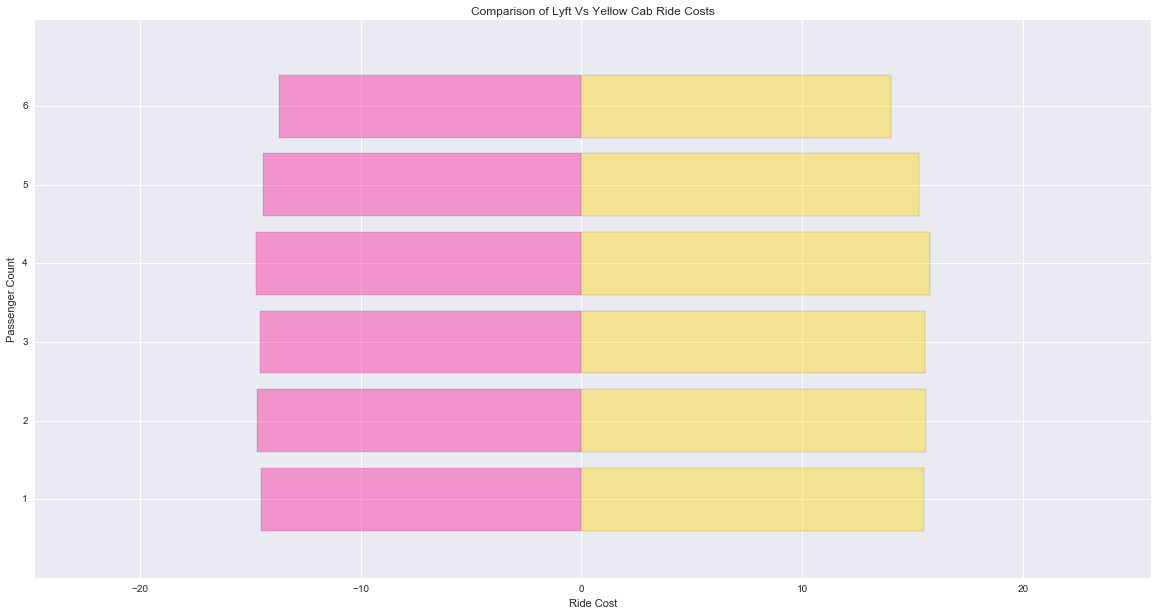

In [15]:
x1 = grouped_df['cost_without_tip']
x2 = grouped_df['estimated_lyft_cost']

bar_labels = grouped_df['passenger_count'].unique()

fig = plt.figure(figsize=(20,10))

y_pos = np.arange(len(x1))
y_pos = [x for x in y_pos]
plt.yticks(y_pos, bar_labels, fontsize=10)

plot1 = plt.barh(y_pos,x1,align='center',alpha=0.4,color='#FFD700')

plt.barh(y_pos,-x2,align='center',alpha=0.4,color='#FF1493')

# annotation and labels
t = plt.title('Comparison of Lyft Vs Yellow Cab Ride Costs')
plt.xlabel('Ride Cost')
plt.ylabel('Passenger Count')
plt.ylim([-1,len(x1)+0.1])
plt.xlim([-max(x2)-5, max(x1)+5])

plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 18 
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.titlesize'] = 32
plt.show()

In [16]:
yellow_cost_df = grouped_df[['passenger_count', 'cost_without_tip']]
yellow_cost_df['Cab Type'] = 'Yellow'
yellow_cost_df = yellow_cost_df.rename(columns={'cost_without_tip':'cost'})

In [17]:
yellow_cost_df

,passenger_count,cost,Cab Type
0,1,15.527082,Yellow
1,2,15.619222,Yellow
2,3,15.563207,Yellow
3,4,15.802088,Yellow
4,5,15.293308,Yellow
5,6,14.042696,Yellow


In [18]:
lyft_cost_df = grouped_df[['passenger_count', 'estimated_lyft_cost']]
lyft_cost_df['Cab Type'] = 'lyft'
lyft_cost_df = lyft_cost_df.rename(columns={'estimated_lyft_cost':'cost'})

In [19]:
lyft_cost_df

,passenger_count,cost,Cab Type
0,1,14.524888,lyft
1,2,14.691039,lyft
2,3,14.589872,lyft
3,4,14.770006,lyft
4,5,14.433477,lyft
5,6,13.716770,lyft


In [20]:
joined_df = pd.concat([yellow_cost_df,lyft_cost_df])

In [21]:
ymax = joined_df.cost.max().round()
ymax

16.0

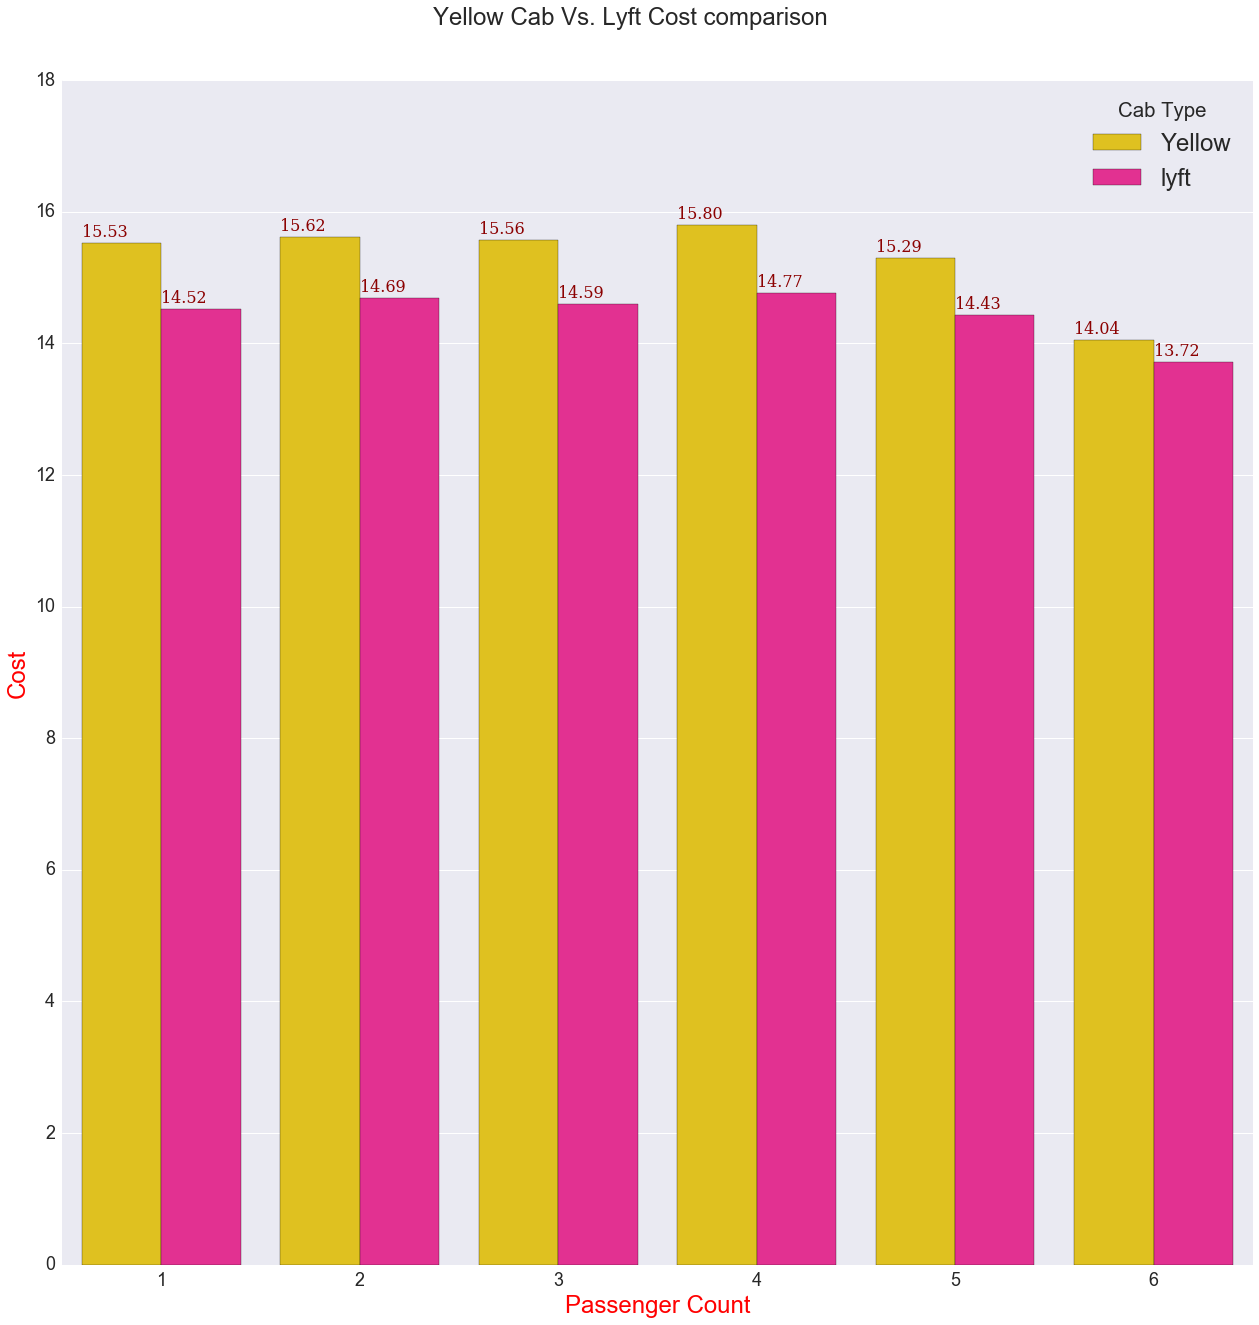

In [22]:
myColors = ["#FFD700","#FF1493"]
rc={'font.size': 24, 'axes.labelsize': 24, 'legend.fontsize': 24.0, 
    'axes.titlesize': 36, 'xtick.labelsize': 18, 'ytick.labelsize': 18}
sns.set(rc=rc)
factor_plot = sns.factorplot(x="passenger_count", y="cost", hue="Cab Type",
                             data=joined_df, kind = 'bar' , size = 18, palette=myColors,
                            legend=True, legend_out=False)
plt.ylim(0, 18)
factor_plot.set()
factor_plot.despine(left=True)
factor_plot.set_xlabels('Passenger Count')
factor_plot.set_ylabels('Cost')
figure_title = factor_plot.fig.suptitle('Yellow Cab Vs. Lyft Cost comparison')
figure_title.set_position([.5, 1.03])

factor_plot.ax.xaxis.label.set_color('#FF0000')
factor_plot.ax.yaxis.label.set_color('#FF0000')

font ={'family': 'serif','color':  'darkred','weight': 'normal','size': 16}

for p in factor_plot.ax.patches:
    percentage = p.get_height()
    factor_plot.ax.text(p.get_x(), percentage+0.1, '%1.2f'%(percentage), fontdict= font)